APAGAR DEPOIS


Requisitos:
- Identificar a localização desenhando um Bounding-Box ao redor da moeda
- Informar o valor da moeda
- Apresentar o desempenho do algoritmo
- Matriz de Confusão e Percentual
- Análise de erros
- Deve-se utilizar um algoritmo de machine learning (KNN, SVM)
- Não é permitido o uso de Deep Learning


comentar funções



# TDE01 


colocar nomes

Colocar descrição

Imports do TDE01 




In [141]:

%matplotlib inline

import os, cv2, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from google.colab.patches import cv2_imshow # for image display

from skimage import io, util
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_otsu, threshold_local, median
from skimage.feature import local_binary_pattern
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.draw import rectangle_perimeter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


 Utilizando o dataset 3 para adquirir as imagens do modelo.


In [142]:

!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset3.zip
!unzip dataset3.zip

imgs = []

for img_path in os.listdir('./dataset3/'):
    
    imgs.append([io.imread('./dataset3/' + img_path),img_path])
    
print(len(imgs),"images loaded")


--2021-09-03 03:59:25--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset3.zip’

dataset3.zip        100%[===================>]  34.10M  10.5MB/s    in 3.3s    

2021-09-03 03:59:30 (10.5 MB/s) - ‘dataset3.zip’ saved [35758483/35758483]

Archive:  dataset3.zip
replace dataset3/5_1477189488.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  


### AJUSTE DO DATASET

#### Normalização

As imagens serão redimensionadas para um tamanho fixo. Isso será feito a fim de padronizar os inputs para processos futuros.

In [143]:

for i in range(len(imgs)):

    imgs[i][0] = np.array(resize(imgs[i][0], (90, 144), anti_aliasing=True))


## COIN DETECTION

Identificar a localização desenhando um Bounding-Box ao redor da moeda

#### Objetivo

Para identificar a localização da moeda, será feita a leitura da imagem como HSV. Uma imagem HSV possui 3 canais: Hue (a cor do pixel), Saturação (a intensidade da cor) e Value (a intensidade da luz sobre o elemento). O primeiro passo para a se identificar essa região é a extração da Saturação da imagem, esse canal será selecionado pois é nele que se encontra com mais precisão a forma dos objetos na imagem. \
Tendo-se o canal de Saturação, a matriz deve ser filtrada para suavizar ruídos na imagem. Além disso, um threshold do canal de Saturação pós-filtragem virá a ser útil para, novamente, suavizar ruídos. Por fim, o resultado de tais operações será transformado para preto e branco. \
Após o préprocessamento da imagem, é preciso ainda identificar a região em que há presença de objetos na imagem. Essa identificação será feita utilizando a funçao "skimage.measure.regionprops", que retorna informações sobre objetos encontrados pela mesma. Objetos que sejam menores do que um tamanho definido devem ser ignorados, pois muito provavelmente são ruídos. Dos objetos como tamanho apropriado, devem ser ignorados aqueles que não tenham proporção 1:1, ou seja, aqueles que ao serem contornados por um quadrado (Bounding Box), estrapolam os limites do mesmo. \

#### Reddies

Essa variável armazena a informação dos retângulos encontrados, será utilizada mais tarde para que seja possível plotar as imagens junto às formas. \

#### Crop

Função auxiliar que recorta a imagem de um ponto a outro. \

#### Cutset

Dados uma imagem e um retângulo, recorta da imagem a região definida pelo retângulo. Chama a função "crop". \

#### Get_good_imgs

A função filtra o resultado do "cutset" nas imagens da base de dados. Caso a moeda não tenha sido encontrada, então ignora-se a imagem.


In [144]:

reddies = []  ## Images with the bounding box drawn to it.

## Draws a box around the coin.
def bbox(image, dimensions=(90,144)) -> ():

    global reddies
    
    ## Resizing images.
    resized = resize(image, dimensions, anti_aliasing=True)

    hsv = rgb2hsv(resized)

    channel_s = hsv[:,:,1]

    channel_filtered = median(channel_s, np.ones((3, 3))) ## Image's histogram median.

    block_size = 20   ## Appling filter on threshold.
    local_thresh = threshold_otsu(channel_filtered, block_size)
    binary_s = channel_filtered > local_thresh ## Removing noise on picture.

    binary = util.img_as_ubyte(binary_s) ## Binary of the s. channel.

    label_image = label(binary) ## Label image regions

    r = regionprops(label_image) ## Getting labels' region. 
    
    rect = None ## Default to none if no regions.
    for region in r:
      
        ## Skip small images.
        if region['Area'] < 60:
            continue
      
        ## Draw rectangle around segmented coins.    
        rect = region['BoundingBox']
      
        ratio = 0
        if  abs(rect[2] - rect[0]) != 0:
            ratio = abs(rect[3] - rect[1]) / abs(rect[2] - rect[0])
        
        ## Eliminating non squared bbox.
        if not (0.90 < ratio < 1.10):         
             continue

        reddy = image.copy()
        start, end = (rect[0], rect[1]), (rect[2], rect[3])
        rr, cc = rectangle_perimeter(start=start, extent=end, shape=image.shape)

        reddy[rr, cc] = [255, 0, 0] ## Setting red to dots in perimeter.
        
        reddies.append(reddy)

        return (rect,binary)

    reddies.append(image)

    ## Returns Rectangle limits pair-values and the image binary.
    return (rect, binary) 
    

## Reduces the image to its pair-values limits(p1 and p2).
def crop (image, p1, p2) -> []:

    return image[ p1[0]+1:p2[0]+1, p1[1]:p2[1] ]

## Calls crop.
## Returns images that didn't default to None on pair-values.
def cutset(imgs, cuts) -> []:
    
    ret = []
    for i in range(len(imgs)):

        if cuts[i] == None:
            
            continue
        
        ret.append(crop(imgs[i][0], [cuts[i][0],cuts[i][1]], [cuts[i][2],cuts[i][3]]) )

    return ret


## Takes cutset's return as parameter.
## Returns images that had been cropped and have valid limits; their binaries and reddies.
nimages_to_use = 0 ## Useful images.
def get_good_imgs(imgs_cutted, imgs, binaries_, reddies_) -> []:

    global nimages_to_use
    
    images_ok, binaries_ok, reddies_ok = [], [], []
    for i in range(len(imgs_cutted)):

        if np.array(imgs_cutted[i]).shape[0] == 0 and np.array(imgs_cutted[i]).shape[1] == 0: 
            
            continue ## Invalid limits.
          
        images_ok.append([imgs_cutted[i], imgs[i][1]])
        binaries_ok.append(binaries_[i])
        reddies_ok.append(reddies_[i])

    nimages_to_use = len(images_ok)

    return images_ok, binaries_ok, reddies_ok


In [145]:

## Limits on each cuttable image. 
imgs_rect_cut = [ bbox(i[0])[0] for i in imgs ]

## Their binaries.
binaries = [ bbox(i[0])[1] for i in imgs ]

## Cropped images.
imgs_cut = cutset(imgs, imgs_rect_cut)

## Useful cropped images, binaries and reddies. 
imgs, binaries, reddies = get_good_imgs(imgs_cut, imgs, binaries, reddies)


2000


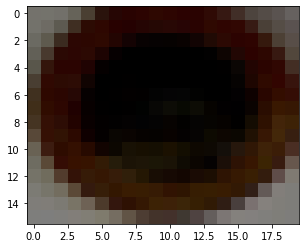

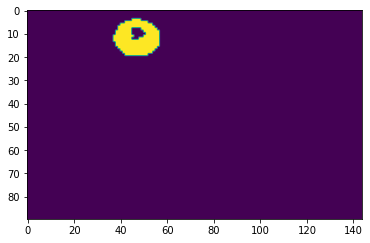

995


'plt.show()'

In [146]:


# detalhar as variáveis binaries, imgs, reddies, nimages_to_use

# mostrar como ele fez usando figure e axes.

# fazer função com tudo esses plots em um figure.

plt.imshow(imgs[40][0])
plt.show()

plt.imshow(binaries[40])
plt.show()

print(len(reddies))
"plt.show()"

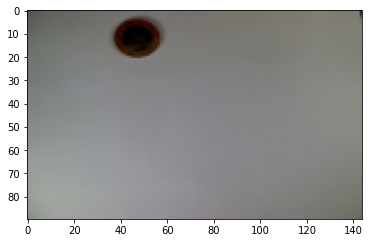

In [155]:
plt.imshow(reddies[40])
plt.show()

## SPLIT DO DATASET


As funções frequenceDict, mapdistribution e load_balance_split são utilizadas para repartir as imagens em dados de treinamento, validação e teste de acordo com a distribuição das classes das imagens de forma a balancear a ocorrência de cada classe em cada partição de dados, isso ajuda a lidar com o desbalanceamento que aprimora a cobertura das classes durante treinamento e avaliação.

- A função frequenceDict calcula a frequência de cada categoria (moeda) no dataset.

- A função mapdistribution lida com o tamanho de cada partição e identifica a quantidade necessaria de cada classe que deve pertencer à cada partição.

- A função load_balance_split efetivamente reparte os dados.


In [147]:

## Calculates de frequence of each category in the data.
def frequenceDict(data) -> {}:

    arr = {}
    for i in data:  ## Initializes the category.
        
        arr[(i[1].split("_")[0])] = 0 

    for i in data:  ## Counts the frequence for the category.
        
        arr[i[1].split("_")[0]] += 1

    return arr


## Maps the amount of items per category per partitions.
def mapdistribution(partitions, freq_dict) -> []:

    ret = []

    ## Initializes a dictionary for each partition with its distribution.
    for p in partitions:
        
        ret_ = {}
        for f in freq_dict.keys():
            
            ## Ignores the remainder of the division if doesn't defaulto to zero.
            ret_[f] = int(freq_dict[f] * p) ## Remainder images won't be used.
        
        ret.append(ret_)

    return ret


## Load-balances the data and divides it into a distribution map. 
def load_balance_split(data, mapdistribution_) -> ():
    
    ret = [ [] for _ in mapdistribution_ ]

    for d in data:

        for match in range(len(mapdistribution_)):

            if mapdistribution_[match][d[1].split("_")[0]] > 0:

                ret[match].append(d)

                mapdistribution_[match][d[1].split("_")[0]] -= 1

                break

    return (*ret,)


###Definindo a Proporção dos Conjuntos e Inicialiando-os.

In [148]:

for i in range(len(imgs)): ## Resizing to smaller dimensions found.

    imgs[i][0] = resize(imgs[i][0], (40, 60), anti_aliasing=True)


## Generates the frequence dictionary of the categories with the list.
freqdict = frequenceDict(imgs)

## Maps the categories items by the set distribution.
mapd = mapdistribution([0.5, 0.2, 0.3], freqdict)

## Retrieves a balanced split from the distribution map.
training, validation, testing = load_balance_split(imgs, mapd)


## Aplicando o LBP no Dataset


A função prepareDataForModel remodela os dados da imagem de 3d para 2d sem perda de informação para que funcionem corretamente com os modelos de predição.

A função setdata realiza normalizações, transformações e enriquecimento da informação nas imagens, com uso principal de local_binary_pattern para enriquecer a representação das moedas e rgb2gray que é necessario para o uso de local_binary_pattern.


In [149]:

METHOD = 'uniform'
radius = 3
n_points = 8 * radius


## Sets the data into a lbp and a value list.
def setdata(data) -> ():

    data_lbp, data_value = [], []

    for d in data:
        
        data_lbp.append(local_binary_pattern(np.array(rgb2gray(d[0])), n_points, radius, METHOD))
        data_value.append(d[1].split("_")[0])

    return np.array(data_lbp), np.array(data_value).reshape(-1,1)


## Prepares the data into the model's data-injection pattern.
def prepareDataForModel(data) -> ():

    d0nsamples, d0x, d0y = data[0].shape
    d1nsamples, d1x = data[1].shape

    return data[0].reshape((d0nsamples,d0x*d0y,)), data[1].reshape((d1nsamples,d1x))


## Data divided by usage and meaning.
## Read it as X_train, y_train and so on.
training_lbp, training_value = prepareDataForModel(setdata(training))
validation_lbp, validation_value = prepareDataForModel(setdata(validation))
testing_lbp, testing_value = prepareDataForModel(setdata(testing))


## MODELOS

Neste trabalho foram utilizados os classificadores KNeighborsClassifier, StandardScaler,  LogisticRegression, AdaBoostClassifier, RandomForestClassifier e DecisionTreeClassifier

In [150]:
## MAYBE NOT USE ADA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

## ## MAYBE NOT USE RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## MAYBE NOT USE DT
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [151]:

## Classifiers.

KNN = KNeighborsClassifier(n_neighbors=15)

SVM = make_pipeline(StandardScaler(), SVC(gamma='auto')) #testar scalers ~ robust scaler.

LOGREG = LogisticRegression(random_state=9, solver='newton-cg', max_iter=1000, multi_class='ovr')
## solver {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

ADA = AdaBoostClassifier(n_estimators=100, random_state=0)

RF = RandomForestClassifier(max_depth=10, random_state=9)

DT = DecisionTreeClassifier(random_state=0)

CLFS = [KNN, SVM, LOGREG, ADA, RF, DT]


In [152]:

[ clf.fit(training_lbp, training_value) for clf in CLFS ];print('\n')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=

In [153]:

preds = [ clf.predict(testing_lbp) for clf in CLFS ]


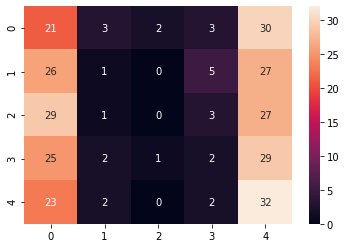

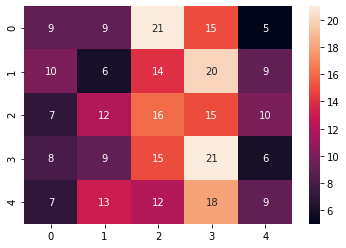

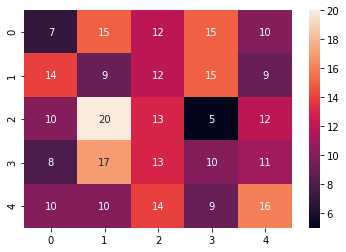

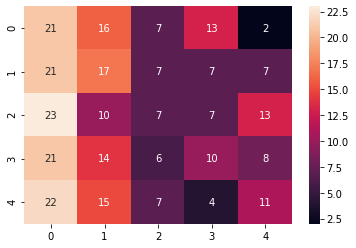

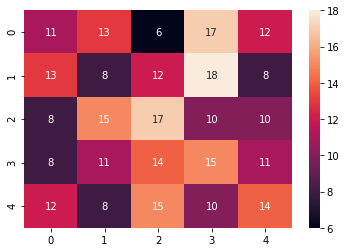

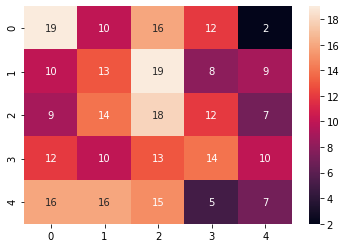

In [154]:

for p in preds:

    sns.heatmap(confusion_matrix(testing_value, p), annot=True)
    plt.show()
